In [697]:
import pandas as pd
import numpy as np


from sklearn.ensemble import RandomForestClassifier as RFC 
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn import metrics
from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

## Identifies columns to keep before modeling

In [447]:
keep_columns = ['date_x',
                'date_y',
                'open',
                'high',
                'low',
                'close',
                'volume',
                'actual_date_x',
                'option_type_x',
                'strike_x',
                'bid_size_1545_x',
                'bid_1545_x',
                'ask_size_1545_x',
                'ask_1545_x',
                'underlying_bid_1545_x',
                'underlying_ask_1545_x',
                'implied_underlying_price_1545_x',
                'active_underlying_price_1545_x',
                'implied_volatility_1545_x',
                'delta_1545_x',
                'gamma_1545_x',
                'theta_1545_x',
                'vega_1545_x',
                'rho_1545_x',
                'bid_size_eod_x',
                'bid_eod_x',
                'ask_size_eod_x',
                'ask_eod_x',
                'underlying_bid_eod_x',
                'underlying_ask_eod_x',
                'vwap_x',
                'open_interest_x',
                'trade_volume', 
               'strike_diff', 
               'date_diff', 
               'imp_diff',
                'ask_diff',
               'active_diff']

## Brings in options and S&P 500 data

In [550]:
options_total = pd.DataFrame()
es_data = pd.read_excel('es_data.xlsx')

options_1 = pd.read_csv('calc_options_5_28.csv')

options_2 = pd.read_csv('calc_options_5_29.csv')

options_3 = pd.read_csv('calc_options_5_30.csv')

options_4 = pd.read_csv('calc_options_12_3.csv')
options_5 = pd.read_csv('calc_options_12_5.csv')
options_6 = pd.read_csv('calc_options_12_6.csv')
options_7 = pd.read_csv('calc_options_12_7.csv')

## Binds options data into 1 dataframe

In [553]:
options_list = [options_1, options_2, options_3, options_4, options_5, options_6, options_7]

options_total = pd.DataFrame()

for i in options_list:
    options_total = options_total.append(i)
options_total['quote_date'] = pd.to_datetime(options_total['quote_date'])
options_total['actual_date'] = pd.to_datetime(options_total.quote_date.dt.date)

## Defines grouping columns and 

In [557]:
min_close = 2300

grouping_columns = ['actual_date','expiration','option_type', 'strike', 
                    'bid_size_1545', 'bid_1545', 'ask_size_1545', 'ask_1545',
                    'underlying_bid_1545', 'underlying_ask_1545','implied_underlying_price_1545',
                    'active_underlying_price_1545','implied_volatility_1545', 
                    'delta_1545', 'gamma_1545', 'theta_1545','vega_1545',
                    'rho_1545', 'bid_size_eod', 'bid_eod', 'ask_size_eod',
                    'ask_eod', 'underlying_bid_eod', 'underlying_ask_eod', 'vwap','open_interest']



nate = pd.DataFrame(options_total.groupby(grouping_columns, as_index = False)['trade_volume'].sum())

final_df = nate.sort_values(by = 'trade_volume', ascending = False)

final_df = nate[(nate.trade_volume >= 10000)]

final_df = final_df[final_df.strike > min_close]

final_df = final_df.sort_values(by = 'trade_volume', ascending = False)

final_df = final_df.sort_values('expiration', ascending = True)

final_df.columns = ['actual_date', 'date','option_type', 'strike', 
                    'bid_size_1545', 'bid_1545', 'ask_size_1545', 'ask_1545',
                    'underlying_bid_1545', 'underlying_ask_1545','implied_underlying_price_1545',
                    'active_underlying_price_1545','implied_volatility_1545', 
                    'delta_1545', 'gamma_1545', 'theta_1545','vega_1545',
                    'rho_1545', 'bid_size_eod', 'bid_eod', 'ask_size_eod',
                    'ask_eod', 'underlying_bid_eod', 'underlying_ask_eod', 'vwap','open_interest',
                    'trade_volume']

min_date = final_df.date.min()

final_df['date'] = pd.to_datetime(final_df['date'])

In [559]:
merged_final = pd.merge(es_data, final_df, how = 'left', on = 'date')

final_merge_df = merged_final.groupby(['actual_date','date', 'option_type', 'strike', 
                    'bid_size_1545', 'bid_1545', 'ask_size_1545', 'ask_1545',
                    'underlying_bid_1545', 'underlying_ask_1545','implied_underlying_price_1545',
                    'active_underlying_price_1545','implied_volatility_1545', 
                    'delta_1545', 'gamma_1545', 'theta_1545','vega_1545',
                    'rho_1545', 'bid_size_eod', 'bid_eod', 'ask_size_eod',
                    'ask_eod', 'underlying_bid_eod', 'underlying_ask_eod', 'vwap','open_interest'], as_index = False)['trade_volume'].max()

final_merge= pd.merge(merged_final, final_merge_df, how = 'left', on = ['trade_volume'])



In [560]:
drop_dups_df = final_merge.sort_values('trade_volume', ascending=False).drop_duplicates(['date_x'])

drop_dups_df = drop_dups_df.sort_values(by = 'date_x', ascending = False)

fillna_df = drop_dups_df.fillna(method = 'ffill')

fillna_df['strike_diff'] = fillna_df['open'] - fillna_df['strike_x']

fillna_df['imp_diff'] = fillna_df['open'] - fillna_df['implied_underlying_price_1545_x']

fillna_df['active_diff'] = fillna_df['open'] - fillna_df['active_underlying_price_1545_x']

fillna_df['ask_diff'] = fillna_df['open'] - fillna_df['underlying_ask_1545_x']

fillna_df['date_diff'] = (fillna_df['date_y'] - fillna_df['date_x']).dt.days

final = fillna_df[fillna_df.date_x >= min_date].sort_values(by = 'date_x', ascending = False)

final = final[keep_columns]

final['diff'] = final['close'].rolling(window=3).apply(lambda x: x[2] - x[1])

final['response'] = final['diff'].rolling(window=2).apply(lambda x: np.where(x[0] > 10, 1, 0))

options_type = pd.get_dummies(final['option_type_x'])

final_test_df = pd.concat([final, options_type], axis = 1)


C:\Users\nathan.ellis\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
C:\Users\nathan.ellis\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:23: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning


In [561]:
final_test_df.columns = ['date', 'date_options',
'open', 
'high', 
'low', 
'close',
'volume',
'actual_date',
'option_type',
'strike',
'bid_size_1545',
'bid_1545',
'ask_size_1545',
'ask_1545',
'underlying_bid_1545',
'underlying_ask_1545',
'implied_underlying_price_1545',
'active_underlying_price_1545',
'implied_volatility_1545',
'delta_1545',
'gamma_1545',
'theta_1545',
'vega_1545',
'rho_1545',
'bid_size_eod',
'bid_eod',
'ask_size_eod',
'ask_eod',
'underlying_bid_eod',
'underlying_ask_eod',
'vwap',
'open_interest',
'trade_volume',
'strike_diff',
'date_diff', 
'imp_diff',
'active_diff',
'ask_diff',                         
'diff',
'response',
'C', 
'P']

In [562]:
final_test_df = final_test_df[~final_test_df.option_type.isnull()]

## Defines features and response variables for testing

In [563]:
features = ['vwap',                                
'gamma_1545',                           
'theta_1545',                           
'bid_1545',                             
'bid_eod',                             
'bid_size_1545', 
           'vwap',
'open_interest',
'trade_volume',
'strike_diff',
'imp_diff', 
'active_diff',
'ask_diff',
'date_diff']  

response = ['low']

X = final_test_df[features].reset_index(drop = True)

y = final_test_df[response].reset_index(drop = True)

In [545]:
features = ['open',
    'bid_size_1545',
'bid_1545',
'ask_size_1545',
'ask_1545',
'underlying_bid_1545',
'underlying_ask_1545',
'implied_underlying_price_1545',
'active_underlying_price_1545',
'implied_volatility_1545',
'delta_1545',
'gamma_1545',
'theta_1545',
'vega_1545',
'rho_1545',
'bid_size_eod',
'bid_eod',
'ask_size_eod',
'ask_eod',
'underlying_bid_eod',
'underlying_ask_eod',
'vwap',
'open_interest',
'trade_volume',
'strike_diff',
'imp_diff', 
'active_diff',
'ask_diff',
'date_diff',
            'C',
            'P']
response = ['low']

X = final_test_df[features].reset_index(drop = True)

y = final_test_df[response].reset_index(drop = True)

## Initiates a time series based model, counts i down in descending order

In [666]:
start_test = 1
stop_test = 150
profits = []
testing = []
actuals = []
lows = []
opens = []
for i in range(start_test, stop_test, 1):
     
    X_test = X[i -1:i]
    X_train = X[i+1:len(X)]
    
    profit = final_test_df['diff'].iloc[i-1]
    low = final_test_df['close'].iloc[i-1]
    open = final_test_df['open'].iloc[i-1]
    
    profits.append(profit)
    lows.append(low)
    opens.append(open)
    
    y_test = y[i -1:i]
    y_train = y[i+1:len(X)]

    y_train = np.ravel(y_train)
    y_test = np.ravel(y_test)
    
    rf = RFR(n_estimators = 100)
    rf.fit(X_train, y_train)
    rf_pred = rf.predict(X_test)
    testing.append(rf_pred)
    actuals.append(y_test)
    
  #  print(rf_pred, y_test, len(X_train), profit)

## Calculates differences between actual and predicted low values on S&P

In [698]:
print('length =', len(nate_2))
for i in range(0, 1000, 1):

    totals = list(zip(testing,actuals,lows,opens,profits))
    nate = pd.DataFrame(totals, columns = ['predicted', 'actual','closes','opens', 'profit'])
    nate['predicted'] = nate['predicted']+5
    nate['pred_diff'] = nate['predicted']- nate['actual']
    limit = 15

    nate['pred_diff'] = np.where(nate['pred_diff'] > limit, limit, nate['pred_diff'])
    nate['depth'] = nate['closes'] - nate['predicted']
    nate['depth'] = np.where(nate['pred_diff'] == limit, -limit, nate['depth'])
    nate['profit'] = nate['depth']*50

    nate = nate.sort_index(ascending = False)


    #nate.profit = nate.profit.shift(periods = 1, fill_value = 0)
    #nate[['lows', 'opens']] = nate[['lows', 'opens']].shift(periods = 1, fill_value = 0)
    #nate['max_low_diff'] =  nate['lows'] - nate['opens']

    nate_2 = nate[nate.pred_diff >=0]

    nate_2['cum_sum'] = nate_2['profit'].cumsum()
    print('limit = ', i, '', nate_2.profit.sum())


length = 60
limit =  0  0
limit =  1  [-926.5]
limit =  2  [-804.125]
limit =  3  [-2573.125]
limit =  4  [-1370.75]
limit =  5  [6657.875]
limit =  6  [7032.875]
limit =  7  [5176.25]
limit =  8  [5116.75]
limit =  9  [4086.25]
limit =  10  [3756.]
limit =  11  [3904.375]
limit =  12  [9408.75]
limit =  13  [8779.75]
limit =  14  [8448.5]
limit =  15  [7098.5]
limit =  16  [5748.5]
limit =  17  [4398.5]
limit =  18  [3331.25]
limit =  19  [2031.25]
limit =  20  [2033.375]
limit =  21  [3174.25]
limit =  22  [2368.25]
limit =  23  [4905.625]
limit =  24  [7965.875]
limit =  25  [7265.875]
limit =  26  [8771.25]
limit =  27  [8171.25]
limit =  28  [10781.25]
limit =  29  [10281.25]
limit =  30  [13461.75]
limit =  31  [13011.75]
limit =  32  [12561.75]
limit =  33  [12111.75]
limit =  34  [11661.75]
limit =  35  [11211.75]
limit =  36  [10761.75]
limit =  37  [10311.75]
limit =  38  [10434.625]
limit =  39  [10034.625]
limit =  40  [9634.625]
limit =  41  [9234.625]
limit =  42  [8834.6

limit =  324  [12353.875]
limit =  325  [12353.875]
limit =  326  [12353.875]
limit =  327  [12353.875]
limit =  328  [12353.875]
limit =  329  [12353.875]
limit =  330  [12353.875]
limit =  331  [12353.875]
limit =  332  [12353.875]
limit =  333  [12353.875]
limit =  334  [12353.875]
limit =  335  [12353.875]
limit =  336  [12353.875]
limit =  337  [12353.875]
limit =  338  [12353.875]
limit =  339  [12353.875]
limit =  340  [12353.875]
limit =  341  [12353.875]
limit =  342  [12353.875]
limit =  343  [12353.875]
limit =  344  [12353.875]
limit =  345  [12353.875]
limit =  346  [12353.875]
limit =  347  [12353.875]
limit =  348  [12353.875]
limit =  349  [12353.875]
limit =  350  [12353.875]
limit =  351  [12353.875]
limit =  352  [12353.875]
limit =  353  [12353.875]
limit =  354  [12353.875]
limit =  355  [12353.875]
limit =  356  [12353.875]
limit =  357  [12353.875]
limit =  358  [12353.875]
limit =  359  [12353.875]
limit =  360  [12353.875]
limit =  361  [12353.875]
limit =  362

limit =  642  [12353.875]
limit =  643  [12353.875]
limit =  644  [12353.875]
limit =  645  [12353.875]
limit =  646  [12353.875]
limit =  647  [12353.875]
limit =  648  [12353.875]
limit =  649  [12353.875]
limit =  650  [12353.875]
limit =  651  [12353.875]
limit =  652  [12353.875]
limit =  653  [12353.875]
limit =  654  [12353.875]
limit =  655  [12353.875]
limit =  656  [12353.875]
limit =  657  [12353.875]
limit =  658  [12353.875]
limit =  659  [12353.875]
limit =  660  [12353.875]
limit =  661  [12353.875]
limit =  662  [12353.875]
limit =  663  [12353.875]
limit =  664  [12353.875]
limit =  665  [12353.875]
limit =  666  [12353.875]
limit =  667  [12353.875]
limit =  668  [12353.875]
limit =  669  [12353.875]
limit =  670  [12353.875]
limit =  671  [12353.875]
limit =  672  [12353.875]
limit =  673  [12353.875]
limit =  674  [12353.875]
limit =  675  [12353.875]
limit =  676  [12353.875]
limit =  677  [12353.875]
limit =  678  [12353.875]
limit =  679  [12353.875]
limit =  680

limit =  960  [12353.875]
limit =  961  [12353.875]
limit =  962  [12353.875]
limit =  963  [12353.875]
limit =  964  [12353.875]
limit =  965  [12353.875]
limit =  966  [12353.875]
limit =  967  [12353.875]
limit =  968  [12353.875]
limit =  969  [12353.875]
limit =  970  [12353.875]
limit =  971  [12353.875]
limit =  972  [12353.875]
limit =  973  [12353.875]
limit =  974  [12353.875]
limit =  975  [12353.875]
limit =  976  [12353.875]
limit =  977  [12353.875]
limit =  978  [12353.875]
limit =  979  [12353.875]
limit =  980  [12353.875]
limit =  981  [12353.875]
limit =  982  [12353.875]
limit =  983  [12353.875]
limit =  984  [12353.875]
limit =  985  [12353.875]
limit =  986  [12353.875]
limit =  987  [12353.875]
limit =  988  [12353.875]
limit =  989  [12353.875]
limit =  990  [12353.875]
limit =  991  [12353.875]
limit =  992  [12353.875]
limit =  993  [12353.875]
limit =  994  [12353.875]
limit =  995  [12353.875]
limit =  996  [12353.875]
limit =  997  [12353.875]
limit =  998

In [694]:
nate_2

,predicted,actual,closes,opens,profit,pred_diff,depth,cum_sum
146,[2770.605],[2770.5],2791.25,2773.50,[1032.249999999999],[0.10500000000001819],[20.644999999999982],[1032.249999999999]
142,[2787.8825],[2781.75],2784.75,2795.25,[-156.62500000000819],[6.132500000000164],[-3.1325000000001637],[875.6249999999909]
140,[2792.52],[2767.5],2791.50,2814.00,-750,15,-15,[125.6249999999909]
138,[2781.73],[2768.5],2771.50,2786.50,[-511.5000000000009],[13.230000000000018],[-10.230000000000018],[-385.87500000001]
137,[2781.5425],[2743.75],2755.00,2775.75,-750,15,-15,[-1135.87500000001]
136,[2748.925],[2726.5],2752.00,2754.50,-750,15,-15,[-1885.87500000001]
127,[2819.0],[2813.75],2862.50,2823.75,[2175.0],[5.25],[43.5],[289.12499999999]
126,[2824.35],[2805.25],2810.75,2859.50,-750,15,-15,[-460.87500000001]
125,[2809.9425],[2789.5],2807.00,2813.00,-750,15,-15,[-1210.87500000001]
124,[2808.38],[2806.0],2823.00,2808.50,[730.9999999999945],[2.380000000000109],[14.61999999999989],[-479.87500000001546]


## Identifies feature importances

                              Importance %
Features                                  
active_diff                       0.230588
ask_diff                          0.223867
open                              0.193641
imp_diff                           0.17453
strike_diff                       0.130885
date_diff                        0.0100454
ask_size_eod                    0.00484534
implied_volatility_1545          0.0044239
trade_volume                    0.00404844
vwap                            0.00355321
implied_underlying_price_1545   0.00259939
ask_eod                         0.00222604
rho_1545                        0.00215254
delta_1545                      0.00187498
underlying_bid_1545             0.00155145
open_interest                   0.00143418
vega_1545                       0.00126908
bid_eod                         0.00116443
bid_size_1545                  0.000955871
theta_1545                     0.000872052
ask_size_1545                  0.000778537
bid_1545   

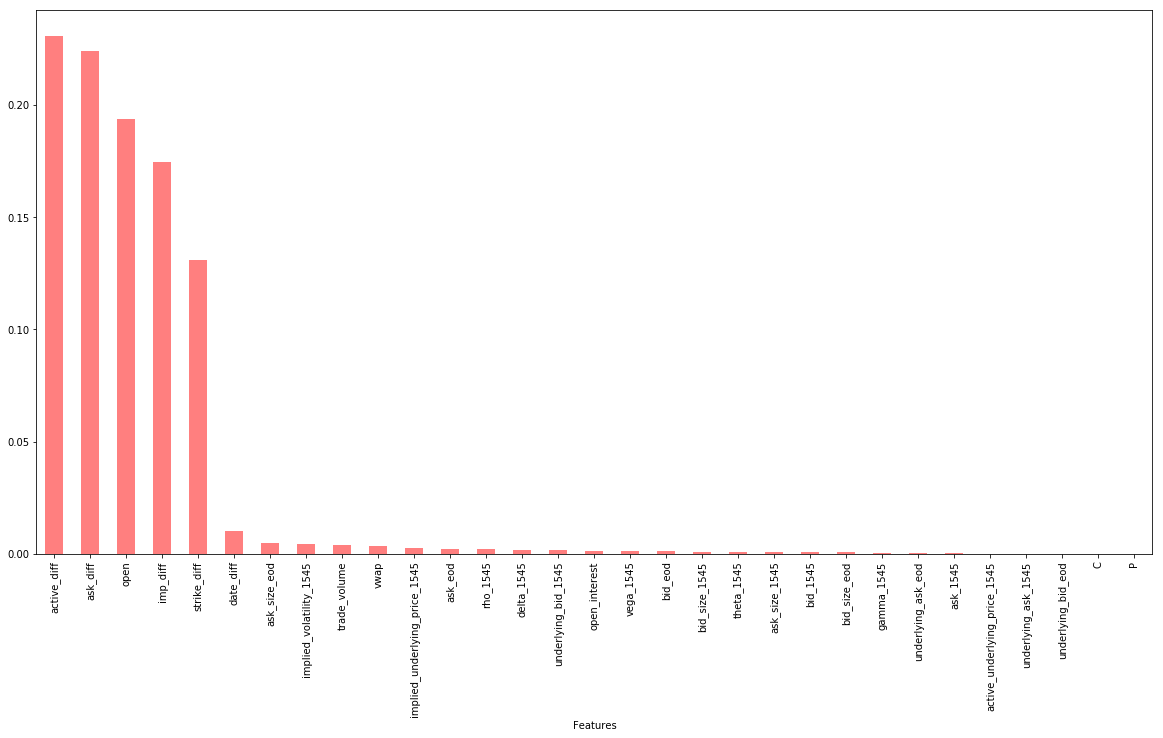

In [549]:
features = X_train.columns

feature_imp = (rf.feature_importances_)

importances = pd.DataFrame([features,feature_imp])

final = importances.transpose()

final.columns = ['Features', 'Importance %']

final = final.sort_values(by = 'Importance %', ascending = False)

final = final.set_index('Features')

print(final)

graph = final['Importance %'].plot(kind = 'bar', color = 'r', alpha = .5,figsize=(20,10),label = 'Actual Strategy Outcomes (from test data)')